In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

torch.__version__

'2.3.0+cu121'

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Generating data



In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:15<00:00, 1702050.95it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 336287.65it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1965961.55it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9223527.12it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, target = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [6]:
classnames = train_data.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_idx = train_data.class_to_idx
class_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
import matplotlib.pyplot as plt

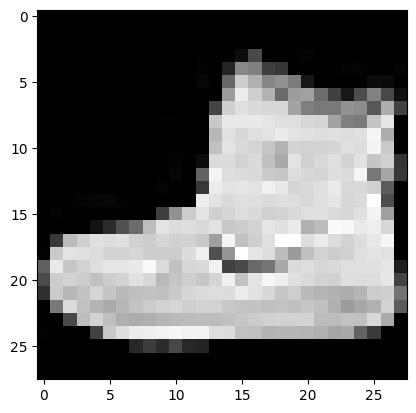

In [10]:
plt.imshow(image.squeeze(),cmap="gray")

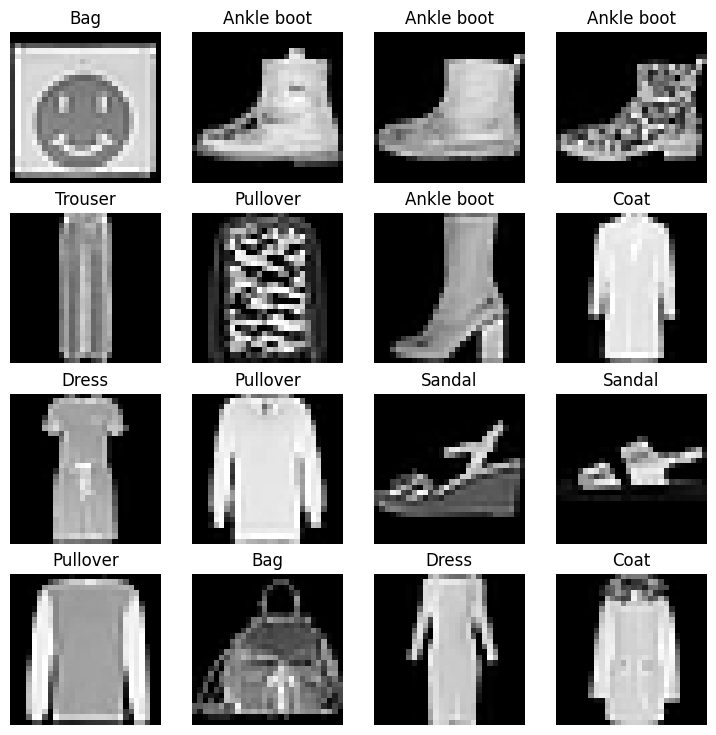

In [11]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
row, col = 4,4
for i in range(1,row*col+1):
  im_index = torch.randint(0,len(train_data),size=[1]).item()
  im, la = train_data[im_index]
  fig.add_subplot(row, col, i)
  plt.imshow(im.squeeze(), cmap="gray")
  plt.title(classnames[la])
  plt.axis(False);

### Loading data using DataLoader

In [21]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)
len(train_dataloader), len(test_dataloader)

313

In [13]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [14]:
flatten = nn.Flatten()
flatten(train_features_batch[1]).shape

torch.Size([1, 784])

### Building baseline model (model_0)

In [15]:
class FashionMNISTModel0(nn.Module):
  def __init__(self, input_size, output_size, hidden_units=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_size)
    )

  def forward(self, x):
    return self.layer_stack(x)

model0 = FashionMNISTModel0(input_size=784,
                      output_size=len(train_data.classes)).to("cpu")
model0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
model0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0312, -0.0329, -0.0136,  ..., -0.0346,  0.0268,  0.0176],
                      [ 0.0096,  0.0298,  0.0174,  ..., -0.0104,  0.0105, -0.0213],
                      [ 0.0142,  0.0321,  0.0274,  ...,  0.0096,  0.0261,  0.0232],
                      ...,
                      [ 0.0060, -0.0343, -0.0152,  ..., -0.0275,  0.0078,  0.0094],
                      [ 0.0348, -0.0162, -0.0025,  ..., -0.0327, -0.0103, -0.0031],
                      [-0.0270, -0.0102, -0.0003,  ...,  0.0036,  0.0137,  0.0267]])),
             ('layer_stack.1.bias',
              tensor([-0.0317, -0.0214, -0.0246,  0.0085, -0.0203, -0.0277,  0.0040, -0.0010,
                      -0.0273,  0.0170])),
             ('layer_stack.2.weight',
              tensor([[-0.2981,  0.0483, -0.2304, -0.0616, -0.0724,  0.0567,  0.2400, -0.2256,
                        0.2929, -0.2767],
                      [-0.2349, -0.2317, -0.1057, -0.2142, -0.1477,  0.1040,  0.

In [26]:
# Setting loss function, optimizer and evaluation metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

def accuracy_fn(y_true, y_pred):
  currect = torch.eq(y_true, y_pred).sum().item()
  accuracy = (currect / len(y_pred)) * 100
  return accuracy
def calaculate_time(start_time,
                    end_time,
                    device="cpu"):
  total_time = end_time - start_time
  print(f"{total_time:.2f}s on {device}")
  return total_time

### training and testing loop

In [27]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 3
train_start_cpu = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    # Training mode
    model0.train()

    # Forward pass
    logits = model0(X)
    y_pred = logits.argmax(dim=1)

    # calculate loss
    loss = loss_fn(logits, y)
    train_loss += loss

    # optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # updating  parameters
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}")

  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:

      # forward pass
      test_logits = model0(X)
      test_pred = test_logits.argmax(dim=1)

      # Loss and accuracy
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y,
                         y_pred=test_pred)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, test_accuracy: {test_acc:.3f}%")
train_end_cpu = timer()
training_time_cpu = calaculate_time(train_start_cpu, train_end_cpu, device= str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.4791, test_loss: 0.4948, test_accuracy: 82.588%
Epoch 1
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.4616, test_loss: 0.4835, test_accuracy: 82.927%
Epoch 2
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train_loss: 0.4491, test_loss: 0.4770, test_accuracy: 83.197%
37.26s on cpu


37.25712099800012

In [34]:
def evaluate_model(model:torch.nn.Module,
                   data_loader:torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      test_logits = model(X)
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y, test_logits.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return {"model": model.__class__.__name__,
          "test_loss": test_loss,
          "test_accuracy": test_acc}

In [36]:
model0_result = evaluate_model(model=model0,
                              data_loader=test_dataloader,
                              loss_fn= loss_fn,
                              accuracy_fn=accuracy_fn)
model0_result

{'model': 'FashionMNISTModel0',
 'test_loss': tensor(0.4770),
 'test_accuracy': 83.19688498402556}

In [40]:
from pathlib import Path

MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True,
                exist_ok=True)
MODEL_NAME = "FashionMNISTClassificationV0.pth"
MODEL_PATH = MODEL_DIR / MODEL_NAME
torch.save(obj = model0.state_dict(),f=MODEL_PATH)